In [1]:
import tensorflow
import keras
import os

Using TensorFlow backend.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2

## Data Preparation :-

In [3]:
df_train = pd.read_csv("dataset/train.csv")

In [4]:
df_test = pd.read_csv("dataset/test.csv")

In [5]:
train_dir = os.path.join('./dataset'+'/train/')
test_dir = os.path.join('./dataset'+'/test/')

In [6]:
train_filename = list(os.listdir(train_dir))
test_filename = list(os.listdir(test_dir))

In [7]:
print(train_filename[:9])
print(test_filename[:9])

['1.jpg', '10.jpg', '100.jpg', '101.jpg', '102.jpg', '103.jpg', '104.jpg', '105.jpg', '106.jpg']
['108.jpg', '11.jpg', '110.jpg', '112.jpg', '114.jpg', '119.jpg', '125.jpg', '128.jpg', '129.jpg']


## Preparing Train Data Images and Target Classes :-

In [8]:
def train_data_prep(list_of_images,df_train,train_dir):
    training_images = []
    training_lables = []
    
    for image in tqdm(list_of_images):
        img = cv2.imread(train_dir+image)
        img = cv2.resize(img,(224,224),interpolation=cv2.INTER_CUBIC)
       # img = img.reshape(1,128,128,3) #no need to reshape 
        training_images.append(img)
        
        if image in list(df_train["Image"]):
            training_lables.append(df_train.loc[df_train['Image']==image,'target'].values[0])
            
    return training_images,training_lables

In [9]:
training_data,training_lables = train_data_prep(train_filename,df_train,train_dir)

100%|████████████████████████████████████████████████████████████████████████████████| 364/364 [00:04<00:00, 81.10it/s]


## Preparing Test Data Image :-

In [10]:
def test_data_prep(list_of_images,test_dir):
    test_images = []
    
    for image in tqdm(list_of_images):
        img = cv2.imread(test_dir+image)
        img = cv2.resize(img,(224,224),interpolation=cv2.INTER_CUBIC)
       # img = img.reshape(1,128,128,3)
        test_images.append(img)
        
    return test_images

In [11]:
test_data = test_data_prep(test_filename,test_dir)

100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 80.47it/s]


## Label Encoding and Train / Test Spliting :-

In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
le = LabelEncoder()

training_labels = le.fit_transform(training_lables)

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
x_train,x_test,y_train,y_test = train_test_split(training_data,training_labels,test_size=0.33,random_state=42,stratify=training_lables)

In [16]:
#df_train['target'].plot(kind='hist',figsize=(10,10))

## Data Augmentation &
### Converting Images Data to a Numpy Array :-

In [17]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

In [18]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   featurewise_center=False,  # set input mean to 0 over the dataset
                                   samplewise_center=False,  # set each sample mean to 0
                                   featurewise_std_normalization=False,  # divide inputs by std of the dataset
                                   samplewise_std_normalization=False,# divide each input by its std
                                   zca_whitening=False,  # apply ZCA whitening
                                   rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
                                   zoom_range = 0.3, # Randomly zoom image 
                                   width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
                                   height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
                                   horizontal_flip=True,  # randomly flip images
                                   vertical_flip=False,
                                  # width_shift_range = [-200,200],
                                   brightness_range = [0.2,1],
                                   fill_mode = 'nearest'
                                  )

test_datagen = ImageDataGenerator(rescale=1./255)

train_datagen.fit(x_train)
test_datagen.fit(x_test)
test_datagen.fit(test_data)

x_train = np.array(x_train)
test_data = np.array(test_data)
x_test = np.array(x_test)

#x_train = preprocess_input(x_train)
#test_data = preprocess_input(test_data)
#x_test = preprocess_input(x_test)


train_set = train_datagen.flow(x_train,
                               to_categorical(y_train,8),
                               batch_size=10)
                               
test_set = test_datagen.flow(x_test,
                            to_categorical(y_test,8),
                            batch_size=2)

###  Data Augmentation with flow_form_dataframe() approach :-

In [ ]:
'''
train_set = df_gen.flow_from_dataframe(dataframe=df_train,
                                      directory="./dataset/train",
                                      x_col='Image',
                                      y_col='target',
                                      batch_size=10, 
                                      class_mode='categorical',
                                      shuffle=True,
                                      subset='training',
                                     #has_ext=True,
                                      target_size=(128,128))

test_set = df_gen.flow_from_dataframe(dataframe=df_train,
                                      directory="./dataset/train",
                                      x_col='Image',
                                      y_col='target',
                                      batch_size=2,
                                      shuffle=False,
                                      class_mode='categorical',
                                      subset='validation',
                                      #has_ext=True,
                                      target_size=(128,128))
'''

In [107]:
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,Dropout,MaxPooling2D,BatchNormalization,GlobalMaxPooling2D,GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from livelossplot import PlotLossesKeras
from keras.optimizers import RMSprop, Adam,SGD
from keras.applications import Xception,ResNet50V2,InceptionV3,MobileNetV2,ResNet50,InceptionResNetV2,VGG16
#from keras.applications.resnet50 import preprocess_input

## Preparing Pre Trained Model For Transfer Learning :-

In [108]:

model_tr = VGG16(include_top=False,
                       pooling=None,
                       weights='imagenet',
                       #input_tensor=None,
                       input_shape=(224,224,3))
model_tr.trainable = False
#for layer in model_tr.layers[:-4]:
 #   layer.trainable=False
    
model_tr.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [99]:
#len(list(model_tr.layers))

## Sequential Model Approach (Transfer Learning) :-

In [109]:

def create_model():
    model = Sequential()
    model.add(model_tr)
    model.add(Flatten())
    model.add(Dropout(0.2))
    #model.add(BatchNormalization())
    #model.add(Dense(64,activation='relu'))
    #model.add(Dropout(0.35))
    #model.add(BatchNormalization())
    #model.add(Dense(512,activation='relu'))
    #model.add(Dropout(0.35))
    #model.add(BatchNormalization())
    #model.add(Dense(128,activation='relu'))
    #model.add(Dropout(0.35))
    #model.add(BatchNormalization())
    #model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.35))
  #  model.add(BatchNormalization())
    model.add(Dense(8,activation='softmax'))
    
    #model.layers[0].trainable = False
    opt = SGD(lr=0.0005,momentum=0.9)
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
    
    return model

model_tl = create_model()
model_tl.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_11 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 25088)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 200712    
Total params: 14,915,400
Trainable params: 200,712
Non-trainable params: 14,714,688
_________________________________________________________________


## Functional API Approch (Transfer Learning) :-

In [ ]:
'''
x = model_tr.output
x = Flatten()(x)
#x = Dropout(0.4)(x)
x = BatchNormalization()(x)
#x = Dense(512,activation='relu',kernel_initializer='uniform')(x)
#x = Dropout(0.25)(x)
#x = BatchNormalization()(x)
#x = Dense(128,activation='relu')(x)
out = Dense(8,activation='softmax')(x)

model_fapi = Model(inputs=model_tr.input,outputs=out)


    
opt = SGD(lr=1e-3,momentum=0.9,decay=1e-6)    
model_fapi.compile(optimizer = opt,loss='categorical_crossentropy',metrics=['accuracy'])
#model_fapi.summary()
'''

## CNN Model From Scratch (Sequential Model) :-

In [ ]:
'''

model_sc = Sequential()

# Convoultion Layer 1
model_sc.add(Conv2D(16,(3,3),input_shape=(224,224,3),activation='relu'))
model_sc.add(BatchNormalization())
model_sc.add(MaxPooling2D(pool_size=(2,2)))
model_sc.add(Dropout(0.5))

# Convoultion Layer 2
model_sc.add(Conv2D(32,(3,3),activation='relu'))
model_sc.add(BatchNormalization())
model_sc.add(MaxPooling2D(pool_size=(2,2)))
model_sc.add(Dropout(0.5))


# Convoultion Layer 3
model_sc.add(Conv2D(32,(3,3),activation='relu'))
#model_sc.add(Conv2D(12,(3,3),activation='relu'))
model_sc.add(BatchNormalization())
model_sc.add(MaxPooling2D(pool_size=(2,2)))
model_sc.add(Dropout(0.5))

# Convoultion Layer 4
model_sc.add(Conv2D(64,(3,3),activation='relu'))
model_sc.add(BatchNormalization())
model_sc.add(MaxPooling2D(pool_size=(2,2)))
model_sc.add(Dropout(0.5))

model_sc.add(Flatten())

model_sc.add(Dense(512,activation='relu'))
model_sc.add(BatchNormalization())
model_sc.add(Dropout(0.4))
model_sc.add(Dense(256,activation='relu'))
model_sc.add(BatchNormalization())
model_sc.add(Dropout(0.4))
model_sc.add(Dense(128,activation='relu'))
model_sc.add(BatchNormalization())
model_sc.add(Dropout(0.4))
model_sc.add(Dense(32,activation='relu'))
model_sc.add(Dense(8,activation='softmax'))

model_sc.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model_sc.summary()


'''

In [110]:
callback = [#ModelCheckpoint('tmp_weights/epoch__{epoch:02d}__acc__{val_accuracy:0.4f}',
                   #        save_weights_only=True,
                    #       save_best_only=True,
                     #      monitor='val_accuracy'),
            EarlyStopping(patience=8,
                         monitor='val_accuracy'),
            PlotLossesKeras(),
            ReduceLROnPlateau(
                              monitor='loss',
                              factor=0.1,
                              patience=2,
                              cooldown=2,
                              min_lr=0.01,
                              )]

## Fitting The Model :-

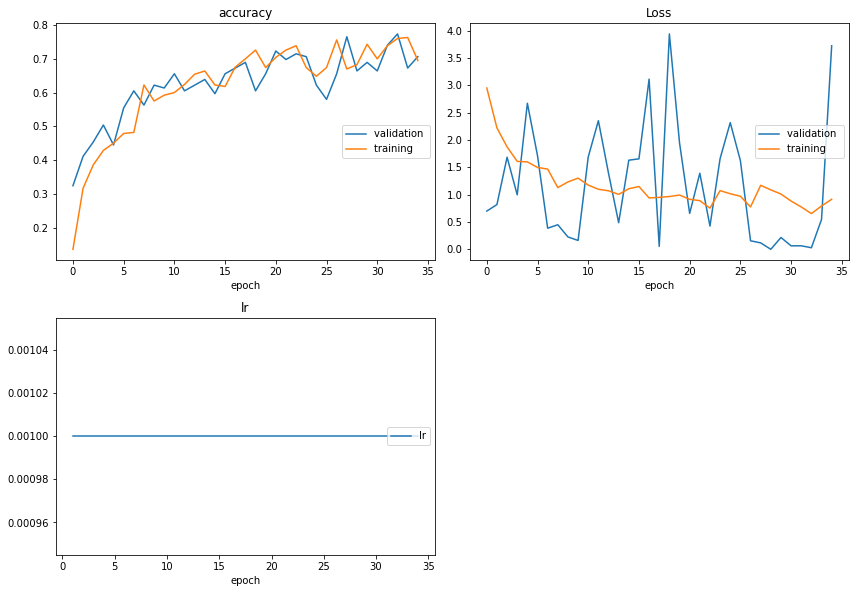

accuracy
	validation       	 (min:    0.325, max:    0.773, cur:    0.706)
	training         	 (min:    0.137, max:    0.762, cur:    0.695)
Loss
	validation       	 (min:    0.002, max:    3.942, cur:    3.725)
	training         	 (min:    0.655, max:    2.952, cur:    0.917)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)


In [111]:
model_tl.fit_generator(train_set,
                   validation_data=test_set,
                   steps_per_epoch=train_set.n//10,
                   validation_steps=test_set.n//2,
                   epochs=35,
                   callbacks=callback)

## Calculating Classification Report :-

In [112]:
from sklearn.metrics import classification_report

In [113]:
y_pred_on_test = model_tl.predict(x_test)
y_pred_on_test = [np.argmax(i) for i in y_pred_on_test]

print(classification_report(y_test,y_pred_on_test))

              precision    recall  f1-score   support

           0       0.52      0.81      0.63        16
           1       1.00      0.47      0.64        15
           2       0.45      0.94      0.61        16
           3       0.44      0.27      0.33        15
           4       1.00      0.08      0.15        12
           5       1.00      0.81      0.90        16
           6       0.45      0.88      0.60        16
           7       1.00      0.13      0.24        15

    accuracy                           0.57       121
   macro avg       0.73      0.55      0.51       121
weighted avg       0.72      0.57      0.53       121



In [ ]:
#df_val = pd.read_csv("dataset/test.csv")

In [ ]:

'''
import cv2
import os
import csv

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.resize(img,(128,128))
        img = img.reshape(1,128,128,3)
        if img is not None:
            images.append(img)
    return images
    
'''

In [35]:
#test_image = load_images_from_folder('dataset/test')

In [ ]:
'''
prediction = []
for i in tqdm(test_image):
    y_pred = model.predict_classes(i)
    prediction.append(y_pred)
'''    

In [ ]:
'''
prediction = list(prediction)
for i in tqdm(range(len(prediction))):
    if prediction[i] == [0]:
        prediction[i] = ['bharatanatyam']        
    if prediction[i] == [1]:
        prediction[i] = ['kathak']
    if prediction[i] == [2]:
        prediction[i] = ['kathakali']
    if prediction[i] == [3]:
        prediction[i] = ['kuchipudi']
    if prediction[i] == [4]:
        prediction[i] = ['manipuri']
    if prediction[i] == [5]:
        prediction[i] = ['mohiniyattam']
    if prediction[i] == [6]:
        prediction[i] = ['odissi']
    if prediction[i] == [7]:
        prediction[i] = ['sattriya']
'''        

In [77]:
#prediction = list(map(list,prediction))

## Predicting on Test Data :-

In [114]:
prediction = model_tl.predict(test_data)
prediction = [np.argmax(i) for i in prediction]
prediction = le.inverse_transform(prediction)

## Writing Predictions and Image Name to .csv file :-

In [116]:
submission = pd.DataFrame({"Image":os.listdir('dataset/test/'),'target':prediction})

In [117]:
submission.to_csv('result.csv',index=False)

In [118]:
import csv

In [ ]:
'''
with open("Submission.csv",'w',newline='') as file:
    csvwriter = csv.writer(file)
    csvwriter.writerow(["target"])
    for i in tqdm(prediction):
        csvwriter.writerow(i)
'''

In [ ]:
'''
with open("Submissions.csv",'w',newline='') as file:
    csvwriter = csv.writer(file)
    csvwriter.writerow(["Image"])
    for i in tqdm(os.listdir("dataset/test")):
        csvwriter.writerow([i])
'''

## Saving Model & Weights :-

In [120]:
model_json = model_tl.to_json()

with open('model.json','w') as file:
    file.write(model_json)

In [122]:
model_tl.save_weights('tmp_weights/weights.h5')